In [15]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

data_path = './data'
data_file = 'weather_prediction_dataset.csv'

In [16]:
with open('../'+data_path + '/' + data_file, 'r') as f:
    data = np.loadtxt(f, delimiter=',', skiprows=1)


dates = data[:, 0]
data = data[:, 2:]

train_dataset = data[:int(0.8*len(data))]
test_dataset = data[int(0.8*len(data)):]

## create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

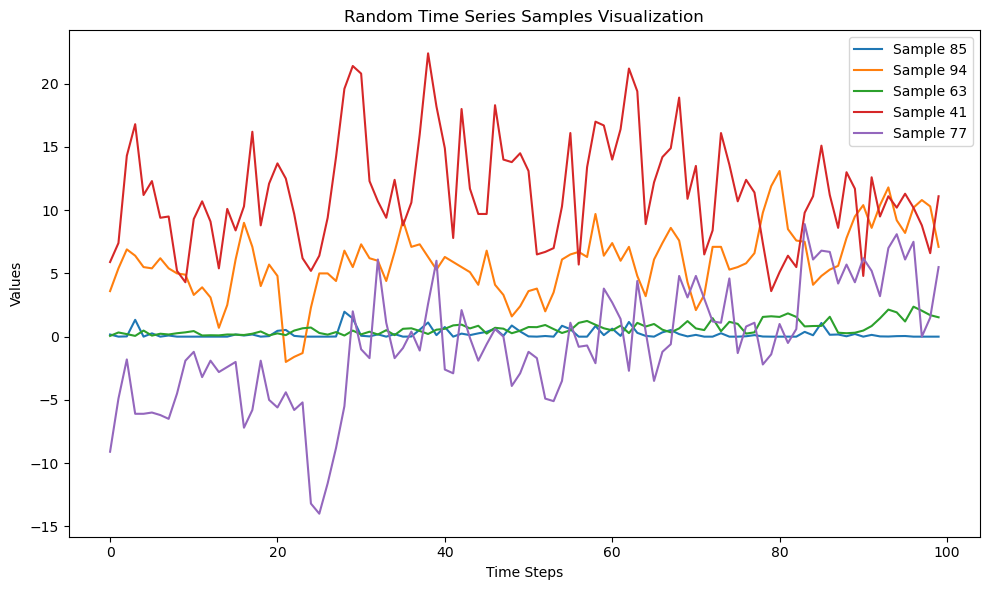

In [17]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
day = next(dataiter)

# first_few_days = [day[i][:] for i in range(num_samples)]
time_series = [day[:, i] for i in range(day.shape[1])]
num_samples = 5  # Define the number of samples you want to plot

# Randomly select indices for plotting
if len(time_series) > num_samples:
    selected_indices = np.random.choice(len(time_series), num_samples, replace=False)
else:
    selected_indices = np.arange(len(time_series))

# Setup the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each selected time series on the same axes
for idx in selected_indices:
    ax.plot(time_series[idx], label=f'Sample {idx + 1}')

# Adding labels and title
ax.set_title('Random Time Series Samples Visualization')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Values')

# Adding a legend to show sample indices
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [18]:
class Encoder(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)
        return mean, log_var

In [29]:
import torch
from torch import nn

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()

    def build_encoder(self):
        return nn.Sequential(
            nn.Linear(self.input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.latent_dim * 2)  # Output both mu and log_var
        )

    def build_decoder(self):
        return nn.Sequential(
            nn.Linear(self.latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.input_dim),
            nn.Sigmoid()  # Often used to output probabilities (e.g., for image pixels)
        )
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x).view(-1, 2, self.latent_dim)
        mu, log_var = encoded[:, 0, :], encoded[:, 1, :]
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return recon_loss + kl_divergence



In [41]:
from torch import optim
from torchvision import datasets, transforms

# testing autoencoder on mnist

# Hyperparameters
input_dim = 784  # MNIST images are 28x28 pixels
latent_dim = 20
batch_size = 64
learning_rate = 1e-3
epochs = 10

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    lambda x: x.clamp(0, 1)  # Ensure the data is clamped between 0 and 1
])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model, Optimizer and Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VariationalAutoencoder(input_dim, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
model.train()
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}')
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device).view(data.size(0), -1)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        loss = model.loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}')

# Visualization of results
model.eval()
with torch.no_grad():
    data, _ = next(iter(train_loader))
    data = data.to(device).view(data.size(0), -1)
    recon_batch, _, _ = model(data)
    # Compare original images with reconstructions
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(20, 4))
    for i in range(10):
        ax[0, i].imshow(data[i].view(28, 28).cpu().numpy(), cmap='gray')
        ax[0, i].axis('off')
        ax[1, i].imshow(recon_batch[i].view(28, 28).cpu().numpy(), cmap='gray')
        ax[1, i].axis('off')
    plt.show()

Epoch 1
Epoch 1, Loss: 146.7756
Epoch 2
Epoch 2, Loss: 111.8355
Epoch 3
Epoch 3, Loss: 104.1201
Epoch 4
Epoch 4, Loss: 100.2256
Epoch 5
Epoch 5, Loss: 97.8932
Epoch 6


KeyboardInterrupt: 

In [47]:
class EnsembleKalmanFilter:
    def __init__(self, n_ensemble, state_dim, obs_dim, model, observation_model, R, Q=None):
        self.n_ensemble = n_ensemble
        self.state_dim = state_dim
        self.obs_dim = obs_dim
        self.model = model
        self.observation_model = observation_model
        self.R = R
        self.Q = Q if Q is not None else np.zeros((state_dim, state_dim))
        self.ensemble = np.random.randn(n_ensemble, state_dim)  # Initialize the state ensemble

    def forecast(self):
        for i in range(self.n_ensemble):
            self.ensemble[i] = self.model(self.ensemble[i])
            self.ensemble[i] += np.random.multivariate_normal(np.zeros(self.state_dim), self.Q)

    def update(self, observation, method='deterministic'):
        Hx = np.array([self.observation_model(member) for member in self.ensemble])
        if method == 'stochastic':
            obs_perturbation = np.random.multivariate_normal(np.zeros(self.obs_dim), self.R, self.n_ensemble)
            perturbed_obs = observation + obs_perturbation
        else:
            perturbed_obs = np.tile(observation, (self.n_ensemble, 1))

        Pyy = np.cov(Hx.T) + self.R
        Pxy = np.cov(self.ensemble.T, Hx.T)[:self.state_dim, self.state_dim:]
        K = np.dot(Pxy, np.linalg.inv(Pyy))
        innovations = perturbed_obs - Hx
        self.ensemble += np.dot(innovations, K.T)

    def get_state_estimate(self):
        return np.mean(self.ensemble, axis=0)

    def run_filter(self, data):
        state_estimates = np.zeros((data.shape[0], self.state_dim))
        for i in range(data.shape[0]):
            self.forecast()
            self.update(data[i], method='stochastic')
            state_estimates[i] = self.get_state_estimate()
        return state_estimates

# Example usage
def model(x):
    return x + np.random.normal(0, 0.1, size=x.shape)  # Simple linear dynamics with noise

def observation_model(x):
    return x[:2]  # Example observation model that observes the first two state variables

In [52]:
import numpy as np

def run_ensemble_kalman_filter(data_path, data_file, state_dim, obs_dim, R, Q, n_ensemble=100):
    # Load the data
    with open(f'../{data_path}/{data_file}', 'r') as f:
        data = np.loadtxt(f, delimiter=',', skiprows=1)
    
    data = data[:, 2:]  # Remove dates, days

    # Split the data into training and testing datasets
    train_dataset = data[:int(0.8 * len(data))]
    test_dataset = data[int(0.8 * len(data)):]

    # Define model and observation model functions
    def model(x):
        return x + np.random.normal(0, 0.1, size=x.shape)  # Simple linear dynamics with noise

    def observation_model(x):
        return x[:obs_dim]  # Observation model that maps state to observed variables

    # Initialize the Ensemble Kalman Filter
    enkf = EnsembleKalmanFilter(n_ensemble, state_dim, obs_dim, model, observation_model, R, Q)

    # Run the filter on the training dataset
    training_state_estimates = enkf.run_filter(train_dataset)
    print("Training State Estimates:\n", training_state_estimates)

    # Run the filter on the testing dataset
    testing_state_estimates = enkf.run_filter(test_dataset)
    print("Testing State Estimates:\n", testing_state_estimates)

    return training_state_estimates, testing_state_estimates

# Example call to the function
state_dim = 163  # Specify the dimension of the state
obs_dim = 163    # Specify the dimension of the observations
Ny = int(round(obs_dim))
sig_obs = 0.01
R_k = (sig_obs**2) * np.eye(Ny, Ny)  # Observation error covariance matrix
Q = np.diag([0.1 for _ in range(state_dim)])   # Process noise covariance matrix

# Example of how to call this function with hypothetical data_path and data_file
train_estimates, test_estimates = run_ensemble_kalman_filter(
    data_path='data',
    data_file='weather_prediction_dataset.csv',
    state_dim=state_dim,
    obs_dim=obs_dim,
    R=R_k,
    Q=Q
)

